In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model

### a. Get the Data:

In [2]:
# Load the fashion_mnist dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Create dictionaries to store the datasets
train_hyeri = {'images': train_images, 'labels': train_labels}
test_hyeri = {'images': test_images, 'labels': test_labels}


4422102/4422102 [==============================] - 0s 0us/step


### b. Data Pre-preprocessing

In [3]:
# Normalize pixel values to range between 0 and 1
train_hyeri['images'] = train_hyeri['images'] / 255.0
test_hyeri['images'] = test_hyeri['images'] / 255.0

# Store normalized pixel values back into the dictionaries
unsupervised_hyeri = {'images': train_hyeri['images']}
supervised_hyeri = {'images': test_hyeri['images']}

# Display the shape of the images
print("Shape of train images:", train_hyeri['images'].shape)
print("Shape of test images:", test_hyeri['images'].shape)

Shape of train images: (60000, 28, 28)
Shape of test images: (10000, 28, 28)


In [4]:
train_hyeri['images'].shape[1:]

(28, 28)

In [5]:
# 1. Implement a custom layer named SampleLayer:
class SampleLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_sigma = inputs
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

# 2. Build the encoder section of the variational autoencoder:
input_dim = train_hyeri['images'].shape[1]
input_img = tf.keras.layers.Input(shape=(input_dim, input_dim, 1))

layer1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
layer2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, name='conv2')(layer1)
layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(layer2)
layer4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4')(layer3)

flatten = tf.keras.layers.Flatten(name='flatten')(layer4)
layer5 = tf.keras.layers.Dense(32, activation='relu', name='dense')(flatten)

z_mu_hyeri = tf.keras.layers.Dense(2, name='z_mean')(layer5)
z_log_sigma_hyeri = tf.keras.layers.Dense(2, name='z_log_sigma')(layer5)

z_hyeri = SampleLayer()([z_mu_hyeri, z_log_sigma_hyeri])

encoder = tf.keras.Model(input_img, [z_mu_hyeri, z_log_sigma_hyeri, z_hyeri], name='encoder')

In [6]:
# 3. Display the summary of the encoder model:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 28, 28, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2 (Conv2D)              (None, 14, 14, 64)           18496     ['conv1[0][0]']               
                                                                                                  
 conv3 (Conv2D)              (None, 14, 14, 64)           36928     ['conv2[0][0]']               
                                                                                            

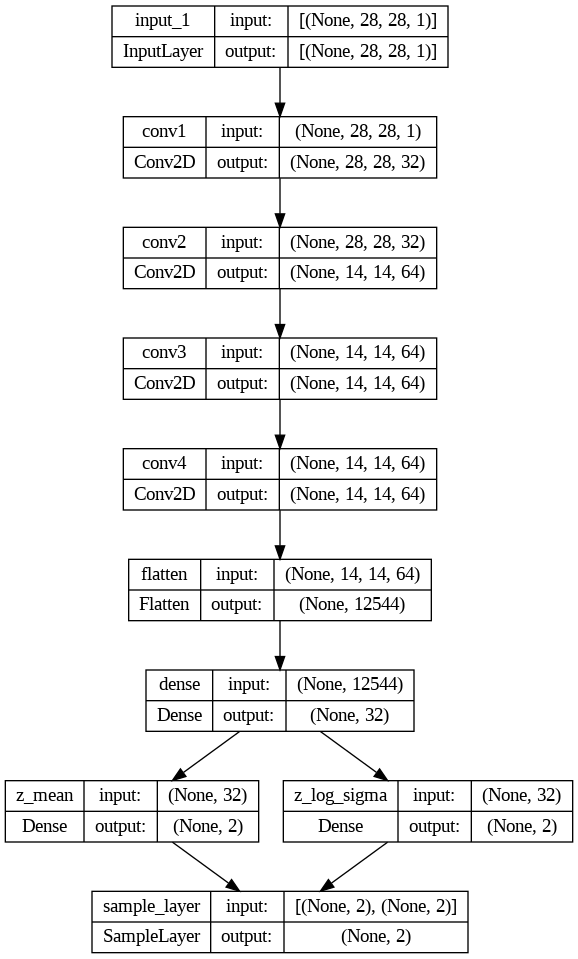

In [7]:
# Draw the diagram for the summary
plot_model(encoder, show_shapes=True, show_layer_names=True)

In [8]:
# 4. Build the decoder section of the variational autoencoder:
latent_inputs = tf.keras.layers.Input(shape=(2,))

# Get the output shape of Layer 4 in the encoder
encoder_layer4 = encoder.get_layer('conv4')

# Use the output shape to determine the number of neurons for layer 1
num_neurons_layer1 = np.prod(encoder_layer4.output_shape[1:])
print("num of fourth layer of encoder: ", num_neurons_layer1)

layer1 = tf.keras.layers.Dense(num_neurons_layer1, activation='relu')(latent_inputs)
layer2 = tf.keras.layers.Reshape(encoder_layer4.output_shape[1:])(layer1)
layer3 = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(layer2)
layer4 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer3)

decoder = tf.keras.Model(latent_inputs, layer4, name='decoder')

num of fourth layer of encoder:  12544


In [9]:
# 5. Display the summary of the decoder model:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 32)        18464     
 anspose)                                                        
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 1)         289       
                                                                 
Total params: 56385 (220.25 KB)
Trainable params: 56385 (220.25 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

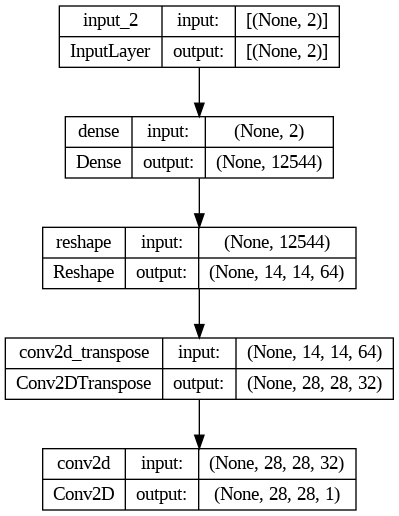

In [10]:
# Draw the diagram for the summary
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [11]:
# 6. Build the Variational Autoencoder (VAE):
outputs = decoder(encoder(input_img)[2])
vae = tf.keras.Model(input_img, outputs, name='vae')

# 7. Display the summary of the VAE model:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               494244    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         56385     
                                                                 
Total params: 550629 (2.10 MB)
Trainable params: 550629 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


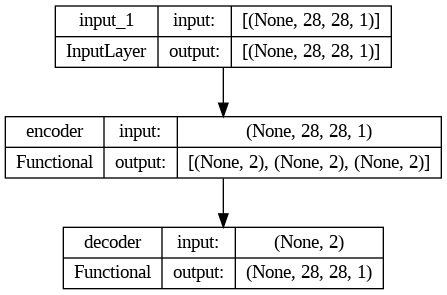

In [12]:
tf.keras.utils.plot_model(vae, show_shapes=True, show_layer_names=True)

### d: Define the KL divergence

In [13]:
kl_loss = -0.5 * tf.reduce_mean(z_mu_hyeri - tf.square(z_mu_hyeri) - tf.exp(z_log_sigma_hyeri) + 1)

###  e: Add the KL loss function to the model

In [14]:
vae.add_loss(kl_loss)

### f: Compile the model

In [15]:
vae.compile(optimizer='adam', loss='mean_squared_error')

### g: Train the VAE

In [16]:
# Train the VAE
epochs = 10
batch_size = 256
history = vae.fit(train_hyeri['images'], train_hyeri['images'], epochs=epochs, batch_size=batch_size)

Epoch 1/10
235/235 [==============================] - 18s 40ms/step - loss: -0.5159
Epoch 2/10
235/235 [==============================] - 9s 39ms/step - loss: -0.5481
Epoch 3/10
235/235 [==============================] - 9s 38ms/step - loss: -0.5643
Epoch 4/10
235/235 [==============================] - 8s 35ms/step - loss: -0.5698
Epoch 5/10
235/235 [==============================] - 8s 33ms/step - loss: -0.5736
Epoch 6/10
235/235 [==============================] - 8s 34ms/step - loss: -0.5744
Epoch 7/10
235/235 [==============================] - 8s 34ms/step - loss: -0.5765
Epoch 8/10
235/235 [==============================] - 8s 34ms/step - loss: -0.5773
Epoch 9/10
235/235 [==============================] - 8s 33ms/step - loss: -0.5780
Epoch 10/10
235/235 [==============================] - 8s 33ms/step - loss: -0.5786


### h: Review sample code

1/1 [==============================] - 0s 18ms/step


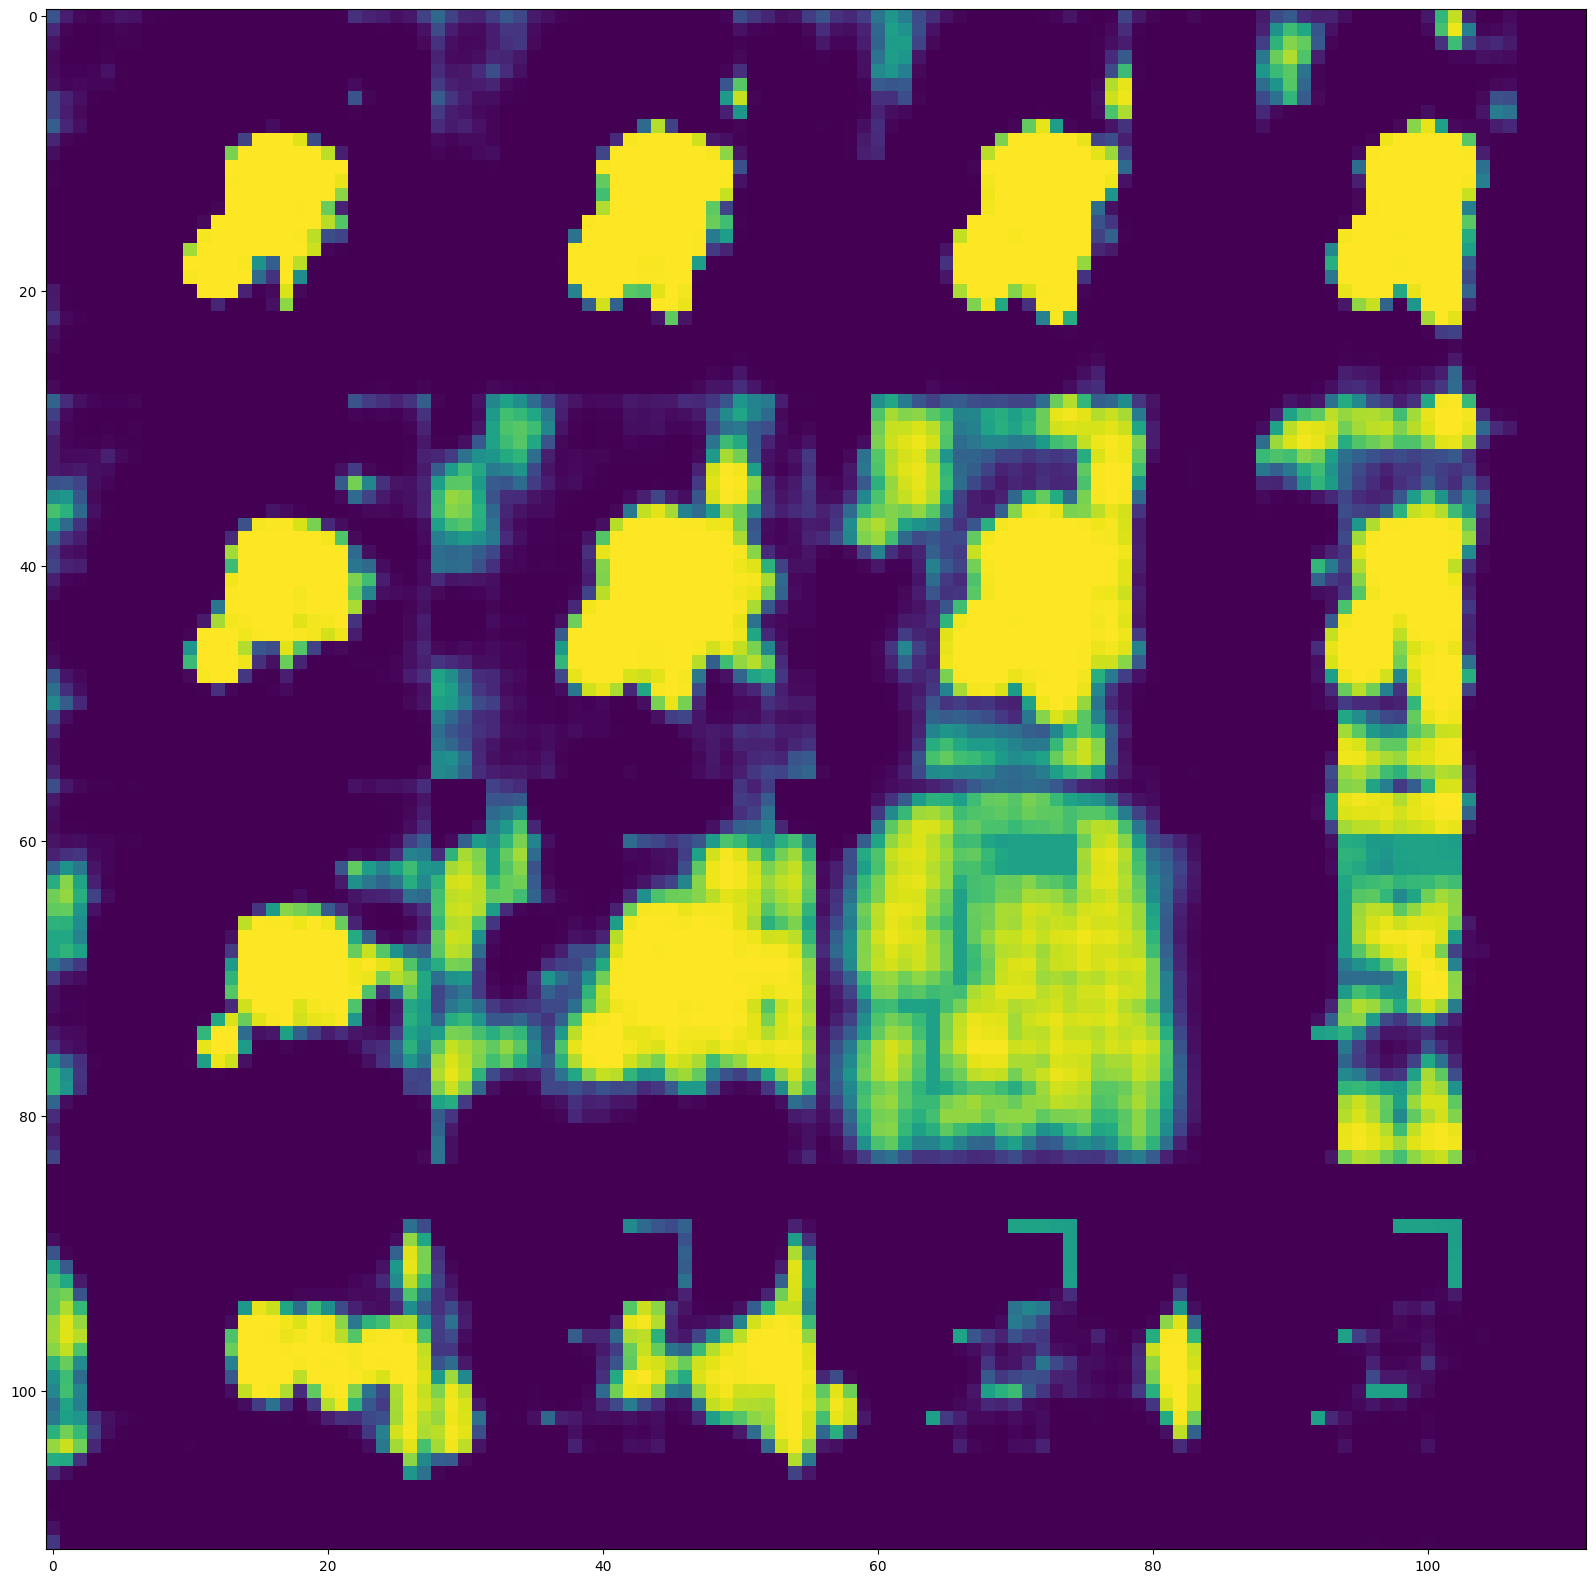

In [17]:
import tensorflow_probability as tfp

n = 4
figure_size = 28

norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

figure = np.zeros((figure_size*n, figure_size*n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    img = x_decoded[0].reshape(figure_size, figure_size)
    figure[i * figure_size: (i + 1) * figure_size,
           j * figure_size: (j + 1) * figure_size] = img
plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### i. Display plot the latent space of z_mu of the test dataset

313/313 [==============================] - 1s 3ms/step


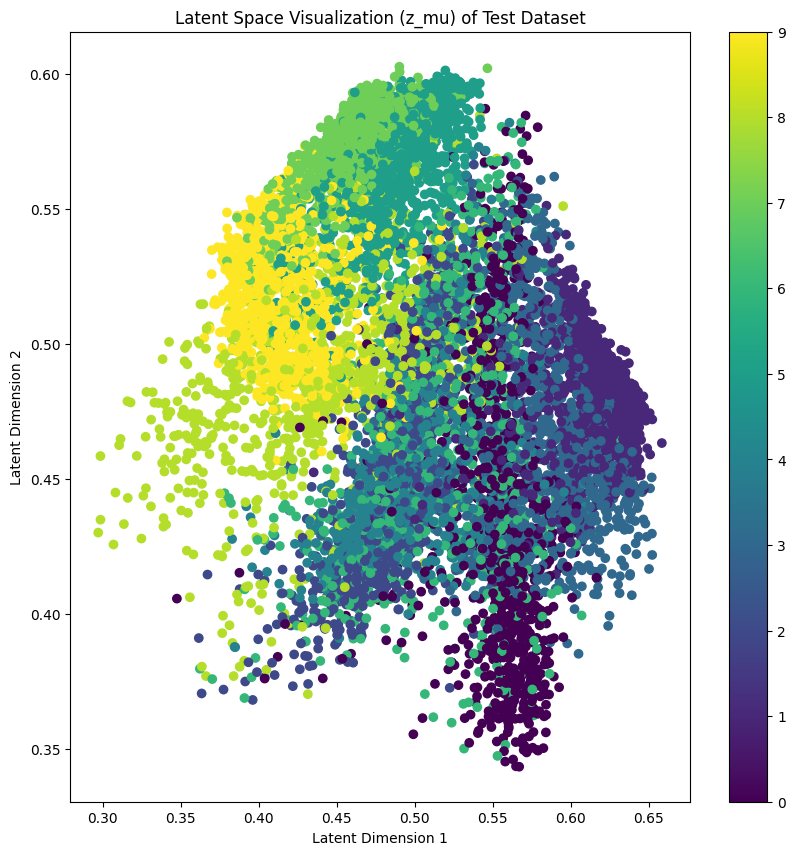

In [22]:
z_mu_test = encoder.predict(test_hyeri['images'])[0]

# Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(z_mu_test[:, 0], z_mu_test[:, 1], c=test_hyeri['labels'], cmap='viridis')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (z_mu) of Test Dataset')
plt.colorbar()
plt.show()